In [5]:
import json
import pandas as pd

In [6]:
# Reading both the large dataset and the user-continent mapping dataset, then merging them.

# File paths
file_path_large_dataset = r'F:\dowloadChrome\pdf\DataFinal.json'
file_path_user_continent = r"F:\dowloadChrome\pdf\user_location_mapping.csv"

# Load the large dataset
with open(file_path_large_dataset, 'r', encoding='utf-8') as file:
    large_dataset = json.load(file)

# Load the user-continent mapping dataset
user_continent_mapping = pd.read_csv(file_path_user_continent)

# Convert the CSV data to a dictionary for easier lookup
continent_dict = user_continent_mapping.set_index('userid')['continent'].to_dict()

# Function to merge continent information based on userid
def merge_continent_data(original_data, continent_dict):
    for entry in original_data:
        user_id = entry['user'].get('id')
        continent = continent_dict.get(user_id)
        if continent:
            entry['continent'] = continent
    return original_data

# Merge the data
merged_data = merge_continent_data(large_dataset, continent_dict)

# Displaying the first few entries of the merged data to verify the changes
merged_data[:5]

[{'user': {'id': 1642910235466821633,
   'username': 'BacosiDura56376',
   'displayName': 'Durante Bacosi',
   'url': 'https://twitter.com/BacosiDura56376',
   'intro': 'bacon geek music fanatic total beer enthusiast lifelong tv maven coffee junkie professional alcohol fanatic web nerd typical food evangelist gamer',
   'join_date': '2023-04-03T15:22:01+00:00',
   'location': 'USA',
   'friends_count': 126,
   'favorite_count': 1210,
   'followers_count': 63,
   'media_count': 142,
   'status_count': 152,
   'listed_count': 0,
   'is_protected': None,
   'is_verified': False,
   'ref': [{'url': 'https://onlyfans.com/sheylaj/c61',
     'text': 'onlyfans.com/sheylaj/c61',
     'tcourl': 'https://t.co/GBoYX26klu'}],
   'account_type': 'human',
   'activities_hour': [11,
    3,
    0,
    0,
    21,
    18,
    18,
    16,
    14,
    12,
    8,
    23,
    15,
    6,
    0,
    23,
    12,
    9,
    6,
    3]},
  'tweets': [{'user': 'BacosiDura56376',
    'tweet_id': 1717510765014311032,

In [7]:
# Filtering the merged dataset to include only entries with a non-None continent field
filtered_data = [entry for entry in merged_data if entry.get('continent') is not None]

# Save the filtered data to a new JSON file
filtered_data_file_path = 'filtered_final_data.json'
with open(filtered_data_file_path, 'w', encoding='utf-8') as file:
    json.dump(filtered_data, file, indent=4)

filtered_data_file_path, len(filtered_data)

('filtered_final_data.json', 3357)

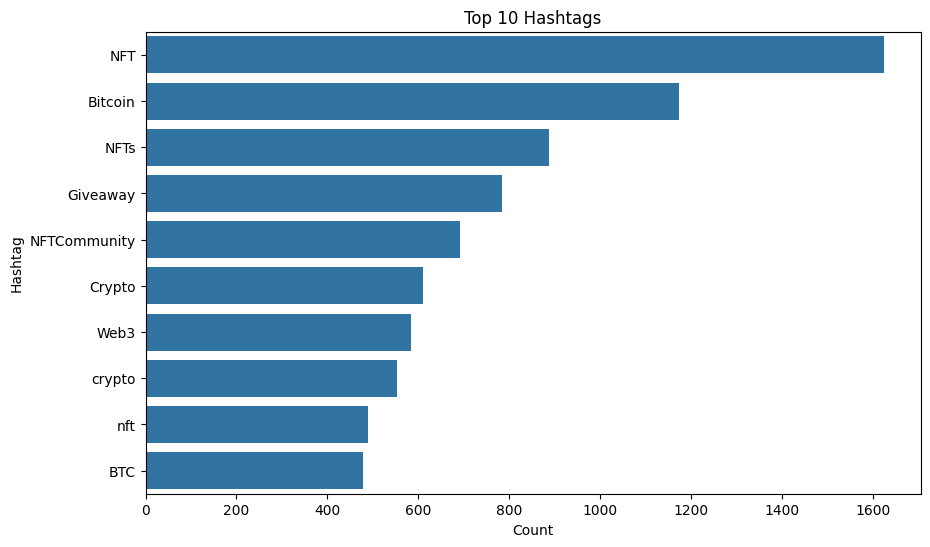

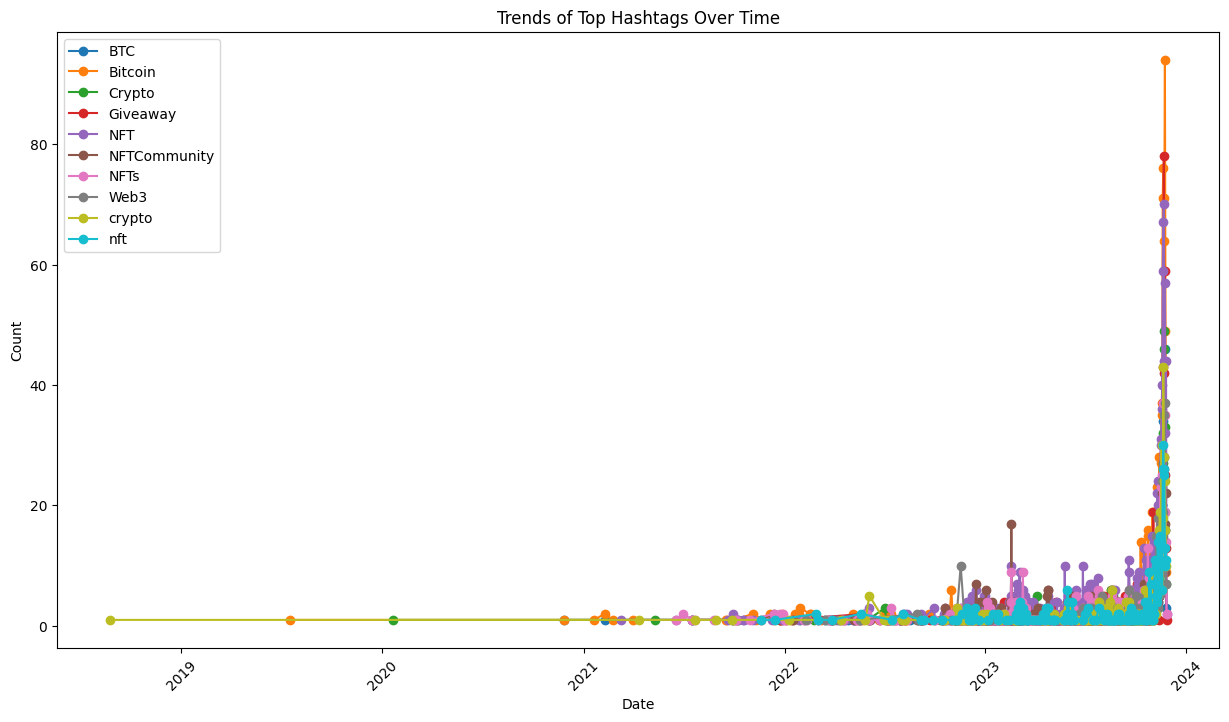

In [8]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the JSON data
file_path = 'filtered_final_data.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract tweets and hashtags
tweets_data = []
hashtags_list = []

for user_data in data:
    for tweet in user_data['tweets']:
        tweet_time = datetime.strptime(tweet['tweet_created_at'], '%Y-%m-%dT%H:%M:%S%z')
        tweets_data.append({
            "tweet_id": tweet['tweet_id'],
            "tweet_content": tweet['tweet_content'],
            "hashtags": tweet['hashtags'],
            "created_at": tweet_time
        })
        hashtags_list.extend(tweet['hashtags'])

# Create DataFrame
tweets_df = pd.DataFrame(tweets_data)

# Count hashtags
hashtags_counter = Counter(hashtags_list)

# Plot top 10 hashtags
top_hashtags = hashtags_counter.most_common(10)
top_hashtags_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Count'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_hashtags_df, x='Count', y='Hashtag')
plt.title('Top 10 Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.show()

# Prepare data for trend analysis
tweets_df['date'] = tweets_df['created_at'].dt.date
tweets_df = tweets_df.explode('hashtags')
hashtag_date_group = tweets_df.groupby(['date', 'hashtags']).size().reset_index(name='counts')

# Plot hashtag trends
plt.figure(figsize=(15, 8))
import matplotlib.pyplot as plt
import numpy as np

# Đảm bảo rằng 'date' và 'counts' được chuyển thành mảng numpy
for hashtag, group in hashtag_date_group.groupby('hashtags'):
    if hashtag in [h[0] for h in top_hashtags]:
        plt.plot(np.array(group['date']), np.array(group['counts']), marker='o', label=hashtag)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Top Hashtags Over Time')
plt.xticks(rotation=45)
plt.show()

In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import re

# Preprocess text function
def preprocess(text):
    text = re.sub(r'user', '', text)  # Remove usernames
    text = re.sub(r'url', '', text)  # Remove RT (retweet tag)
    text = re.sub(r'rt', '', text)
    return text.strip()

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


def get_sentiment_scores(text):
    # Preprocess and truncate the text to fit the model's maximum input size
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=450)
    
    # Get model output
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

In [9]:
# Analyzing tweets in each entry and adding sentiment scores
for entry in filtered_data:
    if 'tweets' in entry:
        for tweet in entry['tweets']:
            tweet_content = tweet['tweet_content']
            scores = get_sentiment_scores(tweet_content)
            sentiment = config.id2label[np.argmax(scores)]
            score = np.max(scores)
            tweet['sentiment'] = {'label': sentiment, 'score': score}
            print(tweet_content, sentiment, score)

# Example of output
print(filtered_data[0])

# Example of output
print(filtered_data[0])

maria whittaker 80 dont know sold watch neutral 0.75153106
would still fuck even though ’ full cum neutral 0.43289977
churchfriends know belief believe panty waste negative 0.72057843
… … position … neutral 0.6020351
want enjoy sweet body positive 0.59039223
favorite color green wanna know neutral 0.6155312
hotkinkyjo fuck gigantic black cock dildo mrhankeys anal fisting prolapse extreme neutral 0.40228224
real fuckdolls dont take selfies talk real fuck doll take cock lot neutral 0.4456813
black heel look great f positive 0.82257134
fucking amanda seyfried prime angelina jolie lingerie foot bigtits neutral 0.57499665
one ’ appreciating hip recently pawg bigass wife sissy positive 0.5540843
dress short enough ebony threesome dildo sucking neutral 0.41045043
want go drive squirting cuckold whitegirl negative 0.45617166
neeko ayatori doggystyle wife sissy hotwife neutral 0.4732619
sucker tongue lingerie pawg jav busty neutral 0.40421838
said “ fuck step bro ” wyd booty whitegirl lesbian s

KeyboardInterrupt: 